Gen AI Homework 1 N-Gram Model - Paul Mitchell, Stephanie Omondiale



In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Preprocessing and Training My Dataset

In [4]:
import os

# Define file paths
base_dir = "/content/drive/MyDrive/N-Gram-Model/"
train_file_student = os.path.join(base_dir, "tokenized_train.txt")
eval_file = os.path.join(base_dir, "tokenized_eval.txt")
test_file = os.path.join(base_dir, "tokenized_test.txt")
train_file_teacher = os.path.join(base_dir, "training.txt")  # Professor's dataset

# Load tokenized training data (Student)
with open(train_file_student, "r", encoding="utf-8") as file:
    tokenized_train_student = [line.strip().split() for line in file.readlines() if line.strip()]

# Load tokenized training data (Teacher)
with open(train_file_teacher, "r", encoding="utf-8") as file:
    tokenized_train_teacher = [line.strip().split() for line in file.readlines() if line.strip()]

# Load evaluation data
with open(eval_file, "r", encoding="utf-8") as file:
    tokenized_eval = [line.strip().split() for line in file.readlines() if line.strip()]

# Load test data
with open(test_file, "r", encoding="utf-8") as file:
    tokenized_test = [line.strip().split() for line in file.readlines() if line.strip()]

# Print sample checks
print(f"✅ Student Training Set: {len(tokenized_train_student)} methods")
print(f"✅ Teacher Training Set: {len(tokenized_train_teacher)} methods")
print(f"✅ Evaluation Set: {len(tokenized_eval)} methods")
print(f"✅ Test Set: {len(tokenized_test)} methods")
print("\n🔹 Sample tokenized method (Student):", tokenized_train_student[0])
print("🔹 Sample tokenized method (Teacher):", tokenized_train_teacher[0])


✅ Student Training Set: 1934 methods
✅ Teacher Training Set: 100000 methods
✅ Evaluation Set: 644 methods
✅ Test Set: 100 methods

🔹 Sample tokenized method (Student): ['private', 'void', 'createBookScan', '(', ')', '{', 'Intent', 'intent', '=', 'new', 'Intent', '(', '"', 'com.google.zxing.client.android.SCAN', '"', ')', ';']
🔹 Sample tokenized method (Teacher): ['boolean', 'function', '(', ')', '{', 'return', 'isParsed', ';', '}']


In [5]:
from collections import Counter

MIN_FREQ = 2  # Adjust based on threshold for rare words

def build_vocab_with_unk(tokenized_data, min_freq):
    word_counts = Counter(token for method in tokenized_data for token in method)
    vocab = {word for word, count in word_counts.items() if count >= min_freq}
    vocab.add("<UNK>")  # Ensure "<UNK>" is explicitly included
    return vocab

# Build vocabularies separately for student and teacher datasets
vocab_student = build_vocab_with_unk(tokenized_train_student, min_freq=MIN_FREQ)
vocab_teacher = build_vocab_with_unk(tokenized_train_teacher, min_freq=MIN_FREQ)

print(f"✅ Student Vocabulary Size: {len(vocab_student)}")
print(f"✅ Teacher Vocabulary Size: {len(vocab_teacher)}")

def preprocess_data_with_unk(tokenized_data, vocab):
    processed_data = []
    for method in tokenized_data:
        processed_method = ["<s>"] + [token if token in vocab else "<UNK>" for token in method] + ["</s>"]
        processed_data.append(processed_method)
    return processed_data

# Apply processing
train_data_student = preprocess_data_with_unk(tokenized_train_student, vocab_student)
train_data_teacher = preprocess_data_with_unk(tokenized_train_teacher, vocab_teacher)
eval_data = preprocess_data_with_unk(tokenized_eval, vocab_student)  # Use student's vocab for eval
test_data = preprocess_data_with_unk(tokenized_test, vocab_student)  # Use student's vocab for test

print(f"✅ Student Training Data Size: {len(train_data_student)}")
print(f"✅ Teacher Training Data Size: {len(train_data_teacher)}")


✅ Student Vocabulary Size: 3216
✅ Teacher Vocabulary Size: 36473
✅ Student Training Data Size: 1934
✅ Teacher Training Data Size: 100000


New
----------

In [9]:
import pickle
from nltk.lm import KneserNeyInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline

def train_kneser_ney_ngram(n, train_data, model_name):
    print(f"\nTraining {n}-Gram Model for {model_name}...")

    train_ngrams, vocab = padded_everygram_pipeline(n, train_data)

    model = KneserNeyInterpolated(n)
    model.fit(train_ngrams, vocab)

    # Save model
    model_path = f"{model_name}_{n}gram_model.pkl"
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    print(f"✅ {n}-Gram Model trained & saved as: {model_path}")

# Train models for student and teacher datasets
for n in [3, 5, 7]:
    train_kneser_ney_ngram(n, train_data_student, "student")
    train_kneser_ney_ngram(n, train_data_teacher, "teacher")



Training 3-Gram Model for student...
✅ 3-Gram Model trained & saved as: student_3gram_model.pkl

Training 3-Gram Model for teacher...
✅ 3-Gram Model trained & saved as: teacher_3gram_model.pkl

Training 5-Gram Model for student...
✅ 5-Gram Model trained & saved as: student_5gram_model.pkl

Training 5-Gram Model for teacher...
✅ 5-Gram Model trained & saved as: teacher_5gram_model.pkl

Training 7-Gram Model for student...
✅ 7-Gram Model trained & saved as: student_7gram_model.pkl

Training 7-Gram Model for teacher...
✅ 7-Gram Model trained & saved as: teacher_7gram_model.pkl


In [11]:
import pickle

# Reload trained models (ensure these files exist)
ngram_models_student = {}
ngram_models_teacher = {}

for n in [3, 5, 7]:
    student_model_path = f"student_{n}gram_model.pkl"
    teacher_model_path = f"teacher_{n}gram_model.pkl"

    try:
        with open(student_model_path, "rb") as f:
            ngram_models_student[n] = pickle.load(f)
        with open(teacher_model_path, "rb") as f:
            ngram_models_teacher[n] = pickle.load(f)
    except FileNotFoundError:
        print(f"❌ Model file not found: {student_model_path} or {teacher_model_path}")


In [15]:
import numpy as np

# Ensure models are loaded
if not ngram_models_student or not ngram_models_teacher:
    raise ValueError("❌ No models loaded. Ensure training has been completed.")

# Compute confidence statistics efficiently
def compute_confidence_stats(models, test_data):
    stats = {}
    for n, model in models.items():
        all_probabilities = [
            model.score(token, method[:i])
            for method in test_data[:100]  # Only first 100 test cases
            for i, token in enumerate(method) if i > 0
        ]
        stats[n] = {
            "mean": np.mean(all_probabilities),
            "median": np.median(all_probabilities)
        }
    return stats

# Run optimized function
confidence_stats_student = compute_confidence_stats(ngram_models_student, test_data)
confidence_stats_teacher = compute_confidence_stats(ngram_models_teacher, test_data)

print("\n✅ Confidence statistics computed successfully.")



✅ Confidence statistics computed successfully.


Analysis for Our (Student) Dataset

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


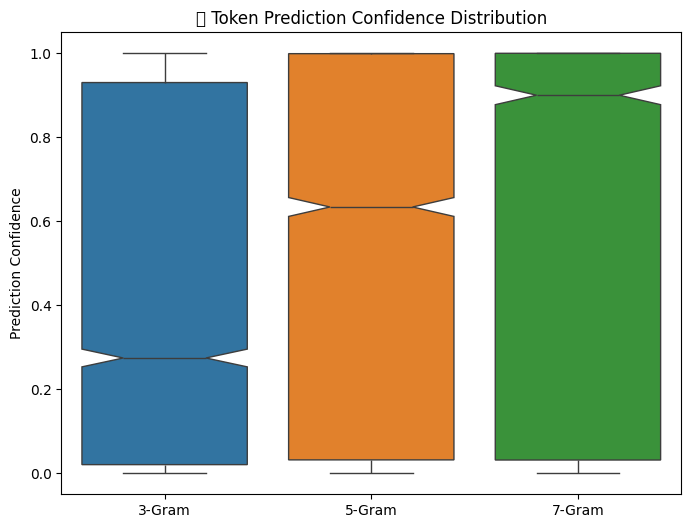

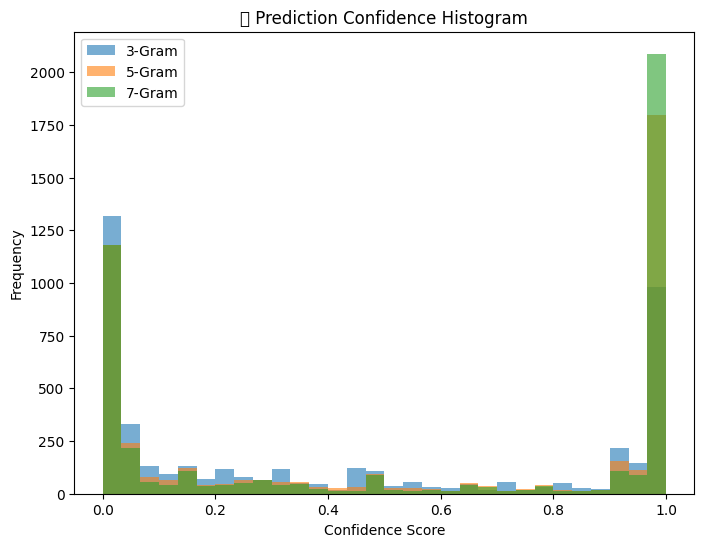


📊 **Confidence Score Summary (Higher is Better):**
🔹 3-Gram Model -> Mean: 0.4234, Median: 0.2745
🔹 5-Gram Model -> Mean: 0.5421, Median: 0.6340
🔹 7-Gram Model -> Mean: 0.5753, Median: 0.9001

🏆 **Best-Performing Model:** 7-Gram (Highest Median Confidence: 0.9001)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 📂 Load trained models
ngram_models = {}
for n in [3, 5, 7]:
    model_path = f"kneserney_{n}gram_model.pkl"
    with open(model_path, "rb") as f:
        ngram_models[n] = pickle.load(f)

# ✅ Compute mean and median probabilities for each model
confidence_stats = {}
all_model_probabilities = {}

for n, model in ngram_models.items():
    all_probabilities = []
    for idx, method in enumerate(test_tokens_replaced[:100]):  # Evaluate on first 100 test cases
        probabilities = [model.score(token, method[:i]) for i, token in enumerate(method) if i > 0]
        all_probabilities.extend(probabilities)

    mean_prob = np.mean(all_probabilities)
    median_prob = np.median(all_probabilities)

    confidence_stats[n] = {"mean": mean_prob, "median": median_prob}
    all_model_probabilities[n] = all_probabilities  # Store all probabilities for visualization

# 📊 Box Plot: Compare confidence distributions
plt.figure(figsize=(8, 6))
sns.boxplot(data=[all_model_probabilities[n] for n in [3, 5, 7]],
            notch=True, showfliers=False)
plt.xticks(range(3), ["3-Gram", "5-Gram", "7-Gram"])
plt.ylabel("Prediction Confidence")
plt.title("📊 Token Prediction Confidence Distribution")
plt.show()

# 📊 Histogram: See confidence frequency distribution
plt.figure(figsize=(8, 6))
for n in [3, 5, 7]:
    plt.hist(all_model_probabilities[n], bins=30, alpha=0.6, label=f"{n}-Gram")

plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("📊 Prediction Confidence Histogram")
plt.legend()
plt.show()

# 🔍 Print numerical results
print("\n📊 **Confidence Score Summary (Higher is Better):**")
for n, stats in confidence_stats.items():
    print(f"🔹 {n}-Gram Model -> Mean: {stats['mean']:.4f}, Median: {stats['median']:.4f}")

# 🏆 Identify the best-performing model
best_n = max(confidence_stats, key=lambda x: confidence_stats[x]['median'])  # Use median confidence
print(f"\n🏆 **Best-Performing Model:** {best_n}-Gram (Highest Median Confidence: {confidence_stats[best_n]['median']:.4f})")


In [46]:
import json

# ✅ Select best-performing model (7-Gram)
best_model_n = 7
best_model_path = f"kneserney_{best_model_n}gram_model.pkl"

# ✅ Load trained model
with open(best_model_path, "rb") as f:
    best_model = pickle.load(f)

# ✅ Generate predictions for test set
student_results = {}

for idx, method in enumerate(test_tokens_replaced[:100]):  # First 100 test cases
    predictions = [
        (token, round(best_model.score(token, method[:i]), 4))
        for i, token in enumerate(method) if i > 0
    ]
    student_results[idx] = predictions

# ✅ Save results to JSON
student_json_path = "/content/drive/MyDrive/N-Gram-Model/results_student_model.json"

with open(student_json_path, "w", encoding="utf-8") as f:
    json.dump(student_results, f, indent=4)

print(f"\n✅ `results_student_model.json` saved successfully at {student_json_path}!")



✅ `results_student_model.json` saved successfully at /content/drive/MyDrive/N-Gram-Model/results_student_model.json!


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


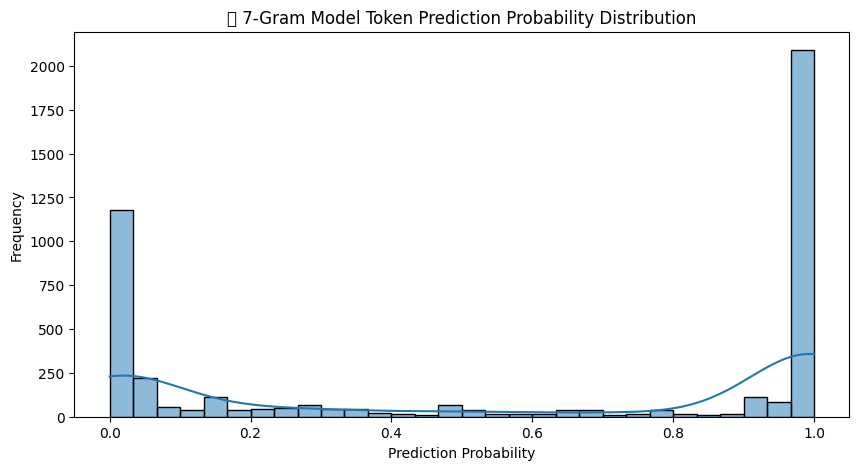

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


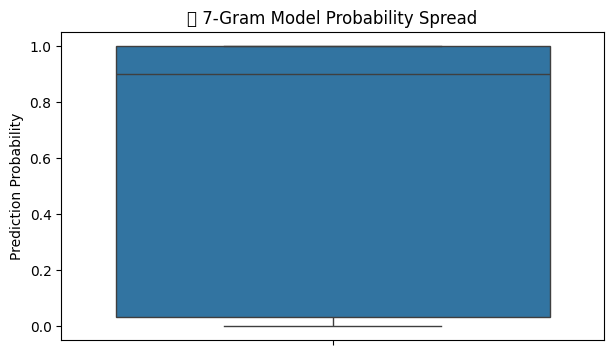

{'Mean Probability': 0.5752904688869412,
 'Median Probability': 0.90015,
 'Max Probability': 1.0,
 'Min Probability': 0.0}

In [49]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load student model results
results_path = "/content/drive/MyDrive/N-Gram-Model/results_student_model.json"

with open(results_path, "r", encoding="utf-8") as f:
    predictions_7gram = json.load(f)

# 📊 Extract probabilities
all_probabilities = [prob for predictions in predictions_7gram.values() for _, prob in predictions]

# 📈 Plot histogram of prediction probabilities
plt.figure(figsize=(10, 5))
sns.histplot(all_probabilities, bins=30, kde=True)
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("📊 7-Gram Model Token Prediction Probability Distribution")
plt.show()

# 📈 Boxplot to see spread of probabilities
plt.figure(figsize=(7, 4))
sns.boxplot(data=all_probabilities)
plt.ylabel("Prediction Probability")
plt.title("📊 7-Gram Model Probability Spread")
plt.show()

# 🔍 Summary Statistics
import numpy as np
prob_summary = {
    "Mean Probability": np.mean(all_probabilities),
    "Median Probability": np.median(all_probabilities),
    "Max Probability": np.max(all_probabilities),
    "Min Probability": np.min(all_probabilities),
}

prob_summary


Graphs for Teacher Prediction Confidence Distributions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load trained teacher models
ngram_models_teacher = {}
for n in [3, 5, 7]:
    model_path = f"kneserney_teacher_{n}gram_model.pkl"
    with open(model_path, "rb") as f:
        ngram_models_teacher[n] = pickle.load(f)

# Compute mean and median probabilities for teacher's model
confidence_stats_teacher = {}
all_model_probabilities_teacher = {}

for n, model in ngram_models_teacher.items():
    all_probabilities = []
    for idx, method in enumerate(test_tokens_replaced[:100]):  # Evaluate on first 100 test cases
        probabilities = [model.score(token, method[:i]) for i, token in enumerate(method) if i > 0]
        all_probabilities.extend(probabilities)

    mean_prob = np.mean(all_probabilities)
    median_prob = np.median(all_probabilities)

    confidence_stats_teacher[n] = {"mean": mean_prob, "median": median_prob}
    all_model_probabilities_teacher[n] = all_probabilities  # Store all probabilities for visualization

# 📊 Box Plot: Compare confidence distributions for teacher's dataset
plt.figure(figsize=(8, 6))
sns.boxplot(data=[all_model_probabilities_teacher[n] for n in [3, 5, 7]],
            notch=True, showfliers=False)
plt.xticks(range(3), ["3-Gram", "5-Gram", "7-Gram"])
plt.ylabel("Prediction Confidence")
plt.title("📊 Teacher's Model - Token Prediction Confidence Distribution")
plt.show()

# 📊 Histogram: See confidence frequency distribution
plt.figure(figsize=(8, 6))
for n in [3, 5, 7]:
    plt.hist(all_model_probabilities_teacher[n], bins=30, alpha=0.6, label=f"{n}-Gram")

plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("📊 Teacher's Model - Prediction Confidence Histogram")
plt.legend()
plt.show()

# 🔍 Print numerical results
print("\n📊 **Confidence Score Summary (Higher is Better) for Teacher's Model:**")
for n, stats in confidence_stats_teacher.items():
    print(f"🔹 {n}-Gram Model -> Mean: {stats['mean']:.4f}, Median: {stats['median']:.4f}")

# 🏆 Identify the best-performing teacher model
best_n_teacher = max(confidence_stats_teacher, key=lambda x: confidence_stats_teacher[x]['median'])
print(f"\n🏆 **Best-Performing Teacher Model:** {best_n_teacher}-Gram (Highest Median Confidence: {confidence_stats_teacher[best_n_teacher]['median']:.4f})")


Predictions for Teacher

In [ ]:
import json

# ✅ Select best-performing teacher model
best_model_n_teacher = best_n_teacher
best_model_path_teacher = f"kneserney_teacher_{best_model_n_teacher}gram_model.pkl"

# ✅ Load trained model
with open(best_model_path_teacher, "rb") as f:
    best_model_teacher = pickle.load(f)

# ✅ Generate predictions for test set
teacher_results = {}

for idx, method in enumerate(test_tokens_replaced[:100]):  # First 100 test cases
    predictions = [
        (token, round(best_model_teacher.score(token, method[:i]), 4))
        for i, token in enumerate(method) if i > 0
    ]
    teacher_results[idx] = predictions

# ✅ Save results to JSON
teacher_json_path = "/content/drive/MyDrive/N-Gram-Model/results_teacher_model.json"

with open(teacher_json_path, "w", encoding="utf-8") as f:
    json.dump(teacher_results, f, indent=4)

print(f"\n✅ `results_teacher_model.json` saved successfully at {teacher_json_path}!")


Results of Teacher’s Model

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load teacher model results
teacher_results_path = "/content/drive/MyDrive/N-Gram-Model/results_teacher_model.json"

with open(teacher_results_path, "r", encoding="utf-8") as f:
    predictions_teacher_7gram = json.load(f)

# 📊 Extract probabilities
all_probabilities_teacher = [prob for predictions in predictions_teacher_7gram.values() for _, prob in predictions]

# 📈 Plot histogram of teacher's prediction probabilities
plt.figure(figsize=(10, 5))
sns.histplot(all_probabilities_teacher, bins=30, kde=True)
plt.xlabel("Prediction Probability")
plt.ylabel("Frequency")
plt.title("📊 Teacher's 7-Gram Model - Token Prediction Probability Distribution")
plt.show()

# 📈 Boxplot to see spread of probabilities
plt.figure(figsize=(7, 4))
sns.boxplot(data=all_probabilities_teacher)
plt.ylabel("Prediction Probability")
plt.title("📊 Teacher's 7-Gram Model Probability Spread")
plt.show()

# 🔍 Summary Statistics
import numpy as np
prob_summary_teacher = {
    "Mean Probability": np.mean(all_probabilities_teacher),
    "Median Probability": np.median(all_probabilities_teacher),
    "Max Probability": np.max(all_probabilities_teacher),
    "Min Probability": np.min(all_probabilities_teacher),
}

prob_summary_teacher
